In [1]:
from traffic_data import METRLADatasetLoader # descarga de datos
import numpy as np # manipulacion de datos
import matplotlib.pyplot as plt # graficar
import torch # crear modelos
from torch.utils.data import TensorDataset, DataLoader # manipular dataset
import torch.nn as nn # para usar las capas predefinidas en torch
import torch.optim as optim # para poder utilizar adam como el optimizador

In [2]:
# cargamos los datos
loader = METRLADatasetLoader() 
adj, weig, x, y = loader.get_dataset(num_timesteps_in=12, 
                                     num_timesteps_out=1)

In [3]:
# omitiremos la variable del tiempo
x = [i[:, 0, :] for i in x]

In [4]:
print(len(x), len(y)) # instancias para entrenamiento
print(x[0].shape) # cada instancia tiene 207 nodos en 12 momentos
print(y[0].shape) # el ground truth es el grafo en el siguiente momento

34260 34260
(207, 12)
(207, 1)


In [5]:
# convertimos la lista a un tensor aumentando una dimension mas
# primero convertimos a array porque es mas eficiente 
X = torch.tensor(np.array(x)).permute(0, 2, 1)
Y = torch.tensor(np.array(y)).permute(0, 2, 1).squeeze()
print(X.shape)
print(Y.shape)

torch.Size([34260, 12, 207])
torch.Size([34260, 207])


In [6]:
# particionamos en train y test y cargamos los datos en objetos
# DataLoader para mejorar la eficiencia

train_p = 0.8 # porcentaje de training
batch_size = 128

train_size = int(train_p * len(X))
test_size = len(X) - train_size

X_train, X_test = torch.split(X, [train_size, test_size])
Y_train, Y_test = torch.split(Y, [train_size, test_size])

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         shuffle=False, drop_last=True)

In [7]:
class LSTMmodel(nn.Module):
    def __init__(self, n_nodes, rnn_hidden_size, 
                 fc_hidden_size, num_layers=1):
        super().__init__()
        # En cada input entran los nodos
        # y en la capa oculta se transforman a rnn_hidden_size
        self.rnn = nn.LSTM(n_nodes, rnn_hidden_size, 
                           batch_first=True, num_layers=num_layers)
        # El estado oculto del ultimo input pasa a una capa lineal
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        # Luego a una funcion de activacion relu
        self.relu = nn.ReLU()
        # Finalmente a una capa lineal sin activacion que retorna valores
        # para los 207 nodos
        self.fc2 = nn.Linear(fc_hidden_size, n_nodes)

    def forward(self, x):
        out, (hidden, cell) = self.rnn(x) # Se obtienen los estados ocultos
        out = hidden[-1, :, :] # obtenemos el ultimo estado oculto
        out = self.fc1(out) # ese estado oculto pasa a la capa lineal
        out = self.relu(out) # luego a la activacion
        out = self.fc2(out) # finalmente a la otra capa lineal
        return out

In [8]:
# inicializamos los parametros del modelo
n_nodes = 207
hidden_size = n_nodes * 2
fc_size = hidden_size * 2

In [9]:
model = LSTMmodel(n_nodes, hidden_size, fc_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [10]:
# Definición de la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossi = []

# Entrenamiento del modelo
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        # Forward 
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        lossi.append(loss.item())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0880
Epoch [2/20], Loss: 0.0681
Epoch [3/20], Loss: 0.1676
Epoch [4/20], Loss: 0.0543
Epoch [5/20], Loss: 0.0517
Epoch [6/20], Loss: 0.0653
Epoch [7/20], Loss: 0.0838
Epoch [8/20], Loss: 0.0563
Epoch [9/20], Loss: 0.0570
Epoch [10/20], Loss: 0.1271
Epoch [11/20], Loss: 0.1227
Epoch [12/20], Loss: 0.0803
Epoch [13/20], Loss: 0.0504
Epoch [14/20], Loss: 0.0494
Epoch [15/20], Loss: 0.0544
Epoch [16/20], Loss: 0.0563
Epoch [17/20], Loss: 0.0491
Epoch [18/20], Loss: 0.0592
Epoch [19/20], Loss: 0.0511
Epoch [20/20], Loss: 0.0553


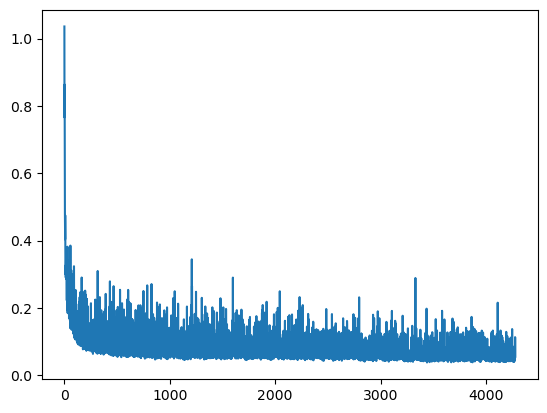

In [11]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
    predicted = model(X_train.to(device))

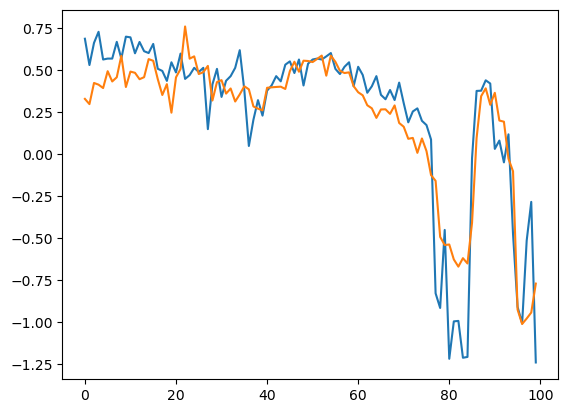

In [13]:
plt.plot([Y_train[i, 5] for i in range(100)]);
plt.plot([predicted[i, 5].cpu() for i in range(100)]);

In [14]:
with torch.no_grad():
    predicted = model(X_test.to(device))

In [15]:
predicted.shape

torch.Size([6852, 207])

In [24]:
Y_test.shape

torch.Size([6852, 207])

In [25]:
mse_test = criterion(predicted, Y_test.to(device)).item()
mse_test

0.18767443299293518